# Part 0: Requirements

In [139]:
# Allow python to import modules from src folders
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import defaultdict
import ast
from collections import Counter
sys.path.append("src/")

from preprocessing.load_dataset import *

SAVE_PATH = "./data/refined"
if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

## Download data  
Please uncomment the following line to download data

In [9]:
# %run src/preprocessing/download_dataset.py

# Part I: Load, explore and join datasets

## CMU dataset

We load the 4 `.tsv` and `.txt` files of the CMU dataset into 4 different dataframes

In [12]:
characters_df = load_characters_df()
movies_df = load_movies_df()
plot_df = load_plot_df()
tvtropes_df = load_tvtropes_df()

### Characters

In [13]:
characters_df.sample(5)

,wiki_movie_id,freebase_movie_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
31259,14143940,/m/03cvyx1,1945,NaN,1908-12-03,M,NaN,NaN,Robert Kent,36.0,/m/0gb0ng_,NaN,/m/065zt6x
158516,35457037,/m/0j9q2pl,2012-05-25,NaN,1986-03-20,F,NaN,NaN,Richa Gangopadhyay,26.0,/m/0mzsf71,NaN,/m/0bxzh5d
206083,10166709,/m/02q3_hb,1943,John (Johann) O. Blenker [Chs. 9-11],1904-02-02,M,NaN,NaN,David Hoffman,38.0,/m/0cv7511,/m/0cv7514,/m/0cv751c
357852,20475363,/m/04zx0rb,2010-12-10,Prospero,1945-07-26,F,1.63,/m/02w7gg,Helen Mirren,65.0,/m/052hdp8,/m/012585,/m/01hkhq
269658,27645415,/m/0gy9d9j,2011-10-11,David Lord,1985-03-15,M,1.85,/m/07hwkr,Kellan Lutz,26.0,/m/0cccvt_,/m/0gyg57w,/m/02pjwn5


In [14]:
total_characters = len(characters_df)
print(f"Number of characters loaded: {total_characters}")
print(f"Number of unique movies: {len(characters_df['wiki_movie_id'].unique())}")
print(f"Number of unique actors: {len(characters_df['freebase_actor_id'].unique())}", end="\n\n")

print(f"Percentage of missing gender: {characters_df['actor_gender'].isna().sum()/total_characters*100:.2f}%")
print(f"Percentage of missing height: {characters_df['actor_height'].isna().sum()/total_characters*100:.2f}%")
print(f"Percentage of missing ethnicity: {characters_df['actor_ethnicity'].isna().sum()/total_characters*100:.2f}%")
print(f"Percentage of missing age upon release: {characters_df['release_actor_age'].isna().sum()/total_characters*100:.2f}%")

Number of characters loaded: 450669
Number of unique movies: 64330
Number of unique actors: 135761

Percentage of missing gender: 10.12%
Percentage of missing height: 65.65%
Percentage of missing ethnicity: 76.47%
Percentage of missing age upon release: 35.08%


In [15]:
print(f"Number of character records for which ethnicity is known: {len(characters_df[~characters_df['actor_ethnicity'].isna()])}")
print(f"Number of unique actors for which ethnicity is known: {len(characters_df[~characters_df['actor_ethnicity'].isna()]['freebase_actor_id'].unique())}")

Number of character records for which ethnicity is known: 106058
Number of unique actors for which ethnicity is known: 8151


### Movies

In [16]:
movies_df.sample(5)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,box_office,movie_runtime,movie_languages,movie_countries,movie_genres
63739,10649757,/m/02ql739,Something to Sing About,1937-09-30,NaN,80.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/01g6gs': 'Black-and-white'}
57052,34835662,/m/0b7bvkb,The Left-Hand Side of the Fridge,2000-09-13,NaN,90.0,{'/m/064_8sq': 'French Language'},{'/m/0d060g': 'Canada'},"{'/m/05p553': 'Comedy film', '/m/0l4h_': 'Mock..."
30084,20903202,/m/05b5rm8,Jaggu,NaN,NaN,NaN,{'/m/03k50': 'Hindi Language'},{'/m/03rk0': 'India'},{'/m/0lsxr': 'Crime Fiction'}
3447,3654610,/m/09sj1n,Samurai Spy,1965,NaN,100.0,{'/m/03_9r': 'Japanese Language'},{'/m/03_3d': 'Japan'},"{'/m/0gw5n2f': 'Japanese Movies', '/m/02kdv5l'..."
72370,36279874,/m/0k2l33t,Yaare Koogadali,2012-11,NaN,NaN,{'/m/09bnf': 'Kannada Language'},{'/m/03rk0': 'India'},{'/m/02l7c8': 'Romance Film'}


In [17]:
total_movies = len(movies_df)
print(f"Number of movies loaded: {total_movies}")
print(f"Percentage of missing box office revenue: {movies_df['box_office'].isna().sum()/total_movies*100:.2f}%")

Number of movies loaded: 81741
Percentage of missing box office revenue: 89.72%


In [18]:
print(f"Number of movies for which we have matching character data: {len(movies_df.merge(characters_df, how='inner', on=['wiki_movie_id', 'freebase_movie_id'])['freebase_movie_id'].unique())}")

Number of movies for which we have matching character data: 64330


In [19]:
# Extract years from the release date of movies
movies_df['movie_release_year'] = movies_df[~movies_df['movie_release_date'].isna()]['movie_release_date'].astype(str).str[:4].astype(int)

# Fix data aberration
wrong_dates = movies_df[movies_df['movie_release_year'] < 1800].index

# A movie that has the release date 1010. We fix the typo to 2010
movies_df.loc[wrong_dates, 'movie_release_year']= 2010
movies_df.loc[wrong_dates, 'movie_release_date'] ='2010-12-02'

### Plot

In [20]:
plot_df.sample(5)

,wiki_movie_id,plot_summary
1151,29129012,"The film portrays the drama between Azem, an A..."
15829,19944417,The KGB plants a nuclear device in the Saudi A...
16994,35182419,"Shin Jin-ah , onetime lead singer of popular g..."
23813,16896550,Various musical notes set up the sheet music t...
26648,6460984,"Two itinerant adventurers, Jim Rainbolt and Sh..."


In [21]:
total_plot = len(plot_df)
print(f"Number of plot summaries loaded: {total_plot}")

Number of plot summaries loaded: 42303


### Tropes

In [22]:
tvtropes_df.sample(5)

,trope_name,character_data
110,corrupt_corporate_executive,"{'char': 'Max Zorin', 'movie': 'A View to a Ki..."
32,bounty_hunter,"{'char': 'Milo Boyd', 'movie': 'The Bounty Hun..."
99,charmer,"{'char': 'Hannibal Lecter', 'movie': 'The Sile..."
37,brainless_beauty,"{'char': 'Paul Metzler', 'movie': 'Election', ..."
57,bruiser_with_a_soft_center,"{'char': 'Hellboy', 'movie': 'Hellboy: Blood a..."


In [23]:
total_tropes = len(tvtropes_df)
print(f"Number of tropes loaded: {total_tropes}")

Number of tropes loaded: 501


## IMDB dataset

We load the 4 `.tsv` files of the IMDB dataset into 4 different dataframes

In [24]:
imdb_ratings_df = load_imdb_ratings()
imdb_title_df = load_imdb_title_basics()
imdb_principals_df = load_imdb_title_principals()
imdb_people_df = load_imdb_person_basics()

### Ratings

In [25]:
imdb_ratings_df.sample(5)

,tconst,averageRating,numVotes
695761,tt14735074,9.4,8
1308196,tt8333106,8.6,62
981065,tt28024843,5.3,41
1052219,tt3700266,7.9,69
698139,tt1478914,7.3,43


We have 1367491 movies for which we have a rating.


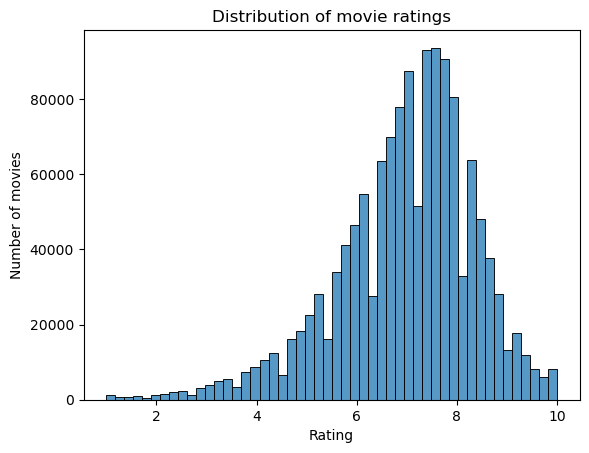

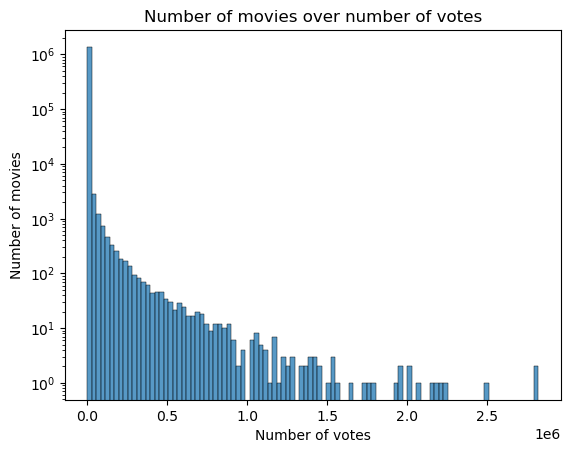

In [26]:
total_ratings = len(imdb_ratings_df)
print(f"We have {total_ratings} movies for which we have a rating.")

# Check the distribution of grades
sns.histplot(data=imdb_ratings_df, x="averageRating", bins=50)

plt.title("Distribution of movie ratings")
plt.xlabel("Rating")
plt.ylabel("Number of movies")
plt.show()

# Check the distribution of votes
sns.histplot(data=imdb_ratings_df, x="numVotes", bins=100)
plt.yscale("log")

plt.title("Number of movies over number of votes")
plt.xlabel("Number of votes")
plt.ylabel("Number of movies")
plt.show()

### Title

In [27]:
imdb_title_df.sample(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
6158659,tt2527566,movie,Figure d'armen,Figure d'armen,0,2012,\N,74,Documentary
375490,tt0391938,movie,Los dorados,Los dorados,0,1921,\N,\N,Drama
310093,tt0323939,movie,Shade,Shade,0,2003,\N,101,"Crime,Thriller"
5981729,tt23734704,movie,Vigilantes,Vigilantes,0,\N,\N,\N,Action
8889826,tt6832538,movie,JFK the Missing Files,JFK the Missing Files,0,\N,\N,\N,Drama


In [28]:
# Remove adult content
imdb_title_df = imdb_title_df[imdb_title_df["isAdult"].astype(int) == 0]

In [29]:
total_title = len(imdb_title_df)
print(f"We have {total_title} movie titles")

We have 652592 movie titles


### Principals

In [30]:
imdb_principals_df.sample(5)

,tconst,ordering,nconst,category,job,characters
32671828,tt21878614,10,nm3882184,actress,\N,"[""María""]"
5809017,tt0776990,7,nm1520609,producer,producer,\N
6319488,tt0847903,3,nm1477053,actress,\N,\N
55028689,tt8553420,7,nm0423493,writer,\N,\N
47662535,tt5689652,2,nm8062077,self,\N,"[""Self - Host""]"


In [31]:
total_principals = len(imdb_principals_df)
print(f"We have {total_principals} principals records")
print(f"We have {len(imdb_principals_df['category'].unique())} categories")
print(f"We have {len(imdb_principals_df['nconst'].unique())} unique persons")


We have 59010065 principals records
We have 12 categories
We have 5176801 unique persons


In [32]:
missing_characters = len(imdb_principals_df[imdb_principals_df['characters'] == "\\N"])
print(f"We have {missing_characters/total_principals*100:.2f}% of missing characters")

We have 51.89% of missing characters


### People

In [33]:
imdb_people_df.sample(5)

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
6523889,nm2167710,Robert Mitchell,\N,\N,miscellaneous,tt0387497
9343613,nm5374448,György Horváth,\N,\N,production_manager,"tt0849411,tt4366790,tt2475362,tt0431871"
1100833,nm10192882,Felicia Richards,\N,\N,miscellaneous,tt0072584
7996102,nm3819728,Márta Náfrádi,\N,\N,animation_department,"tt0114349,tt0179955"
3830387,nm13071410,Joel Leis,\N,\N,camera_department,tt15788212


In [34]:
total_people = len(imdb_people_df)
print(f"We have {total_people} people records")
print(f"We have {len(imdb_people_df['nconst'].unique())} unique persons")
print(f"We have {len(imdb_people_df[imdb_people_df['primaryProfession'] == 'actor'])} unique actors")

We have 12997049 people records
We have 12997049 unique persons
We have 2347021 unique actors


### Movie titles with ratings

In [35]:
imdb_title_with_rating = imdb_title_df.merge(imdb_ratings_df, on='tconst', how='inner')
imdb_title_with_rating.sample(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
103197,tt0280584,movie,Danger Biscuit,Danger Biscuit,0,1969,\N,\N,Drama,6.1,14
272022,tt6513334,movie,Gold Coins,Gold Coins,0,2017,\N,145,Family,7.8,23
183254,tt1525552,movie,Apart,Apart,0,2011,\N,85,"Drama,Mystery,Romance",5.4,615
257236,tt5104676,movie,Öyle ya da Böyle,Öyle ya da Böyle,0,2015,\N,92,"Comedy,Drama",5.0,84
60023,tt0110118,movie,Improper Conduct,Improper Conduct,0,1994,\N,93,Thriller,4.1,235


In [36]:
total_movies_w_rating = len(imdb_title_with_rating)
print(f"We have {total_movies_w_rating} movies with ratings")

We have 295106 movies with ratings


## Merge CMU movies and plot summaries with IMDB titles and ratings

The translation dataframe from wikidata, which includes both the IMDB id and the Freebase id, enables us to combine the IMDB dataset with the CMU dataset

In [37]:
translation_id = load_translation_df()

In [38]:
imdb_title_with_rating_translated = imdb_title_with_rating.merge(translation_id, how='inner', left_on='tconst', right_on='imdb_id').copy()
imdb_title_with_rating_translated = imdb_title_with_rating_translated.drop(["imdb_id"], axis=1)

In [39]:
cmu_movies_w_imdb_rating = imdb_title_with_rating_translated.merge(movies_df, how='inner', left_on='freebase_id', right_on='freebase_movie_id').copy()

In [40]:
# IMDB start year has no missing data, so we insert it into "NaN" fields of "movie_release_date" and drop "startYear"
missing_years = cmu_movies_w_imdb_rating[cmu_movies_w_imdb_rating['movie_release_date'].isna()].index
cmu_movies_w_imdb_rating.loc[missing_years, 'movie_release_date'] = cmu_movies_w_imdb_rating.loc[missing_years, 'startYear']

In [41]:
# We have MANY depulicated attributes
# We evaluated for each pair which column had more missing data and dropped it in favor of the other
cmu_movies_w_imdb_rating = cmu_movies_w_imdb_rating.drop(["freebase_movie_id", "titleType", "isAdult", "endYear", "primaryTitle", "originalTitle", "movie_release_year", "movie_runtime", "startYear"], axis=1)

In [42]:
cmu_movies_w_imdb_rating = cmu_movies_w_imdb_rating.drop_duplicates("tconst")
print(f"The merged dataframe contains {len(cmu_movies_w_imdb_rating)} movies with corresponding ratings")

The merged dataframe contains 44474 movies with corresponding ratings


In [43]:
# Add summaries
cmu_movies_w_imdb_rating = cmu_movies_w_imdb_rating.merge(plot_df, on="wiki_movie_id", how="left")

In [44]:
cmu_movies_w_imdb_rating.sample(5)

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,movie_languages,movie_countries,movie_genres,plot_summary
43847,tt2027265,110,Drama,6.6,1784,/m/0h32j7x,33820074,A Better Life,2011-09-13,NaN,"{'/m/064_8sq': 'French Language', '/m/02h40lc'...","{'/m/0f8l9c': 'France', '/m/0d060g': 'Canada'}",{'/m/07s9rl0': 'Drama'},Yann and Nadia fall in love. Nadia has acqui...
8756,tt0045117,75,"Crime,Drama",5.8,101,/m/0dlnshp,29254831,Salute the Toff,1952-01,NaN,{'/m/02h40lc': 'English Language'},{},"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...",The Honourable Richard Rollison is a well-kno...
31109,tt0254284,93,"Comedy,Drama",4.9,237,/m/03csdnc,14063136,Dog Eat Dog,2001-10-08,NaN,{'/m/02h40lc': 'English Language'},"{'/m/07ssc': 'United Kingdom', '/m/0345h': 'Ge...","{'/m/07s9rl0': 'Drama', '/m/01z4y': 'Comedy'}","Four friends, Rooster, CJ, Jess and Chang, dre..."
4070,tt0029694,63,"Drama,Music,Western",5.2,292,/m/0b75f7j,26263186,Trouble in Texas,1937,NaN,{},{'/m/09c7w0': 'United States of America'},"{'/m/0hfjk': 'Western', '/m/02kdv5l': 'Action'...",NaN
21266,tt0093156,99,Drama,6.1,75,/m/05zm37p,22644715,Havinck,1987-10-15,NaN,{'/m/02bv9': 'Dutch Language'},{'/m/059j2': 'Netherlands'},{'/m/07s9rl0': 'Drama'},NaN


## Merge IMDB people and principals

In [45]:
titles_of_interest = cmu_movies_w_imdb_rating["tconst"].to_list()

In [46]:
imdb_actors = imdb_people_df[(imdb_people_df["primaryProfession"].str.contains("actor")) | (imdb_people_df["primaryProfession"].str.contains("actoress"))].copy()

In [47]:
imdb_principals_actors = imdb_principals_df[(imdb_principals_df["category"] == "actress") | (imdb_principals_df["category"] == "actor")].copy()

In [48]:
imdb_actors_and_characters = imdb_actors.merge(imdb_principals_actors, on="nconst", how="inner").copy()

In [49]:
imdb_actors_and_characters = imdb_actors_and_characters[imdb_actors_and_characters["tconst"].isin(titles_of_interest)]

In [50]:
imdb_actors_and_characters = imdb_actors_and_characters.drop(["ordering", "category", "job", "primaryProfession"], axis=1)

In [51]:
imdb_actors_and_characters.head(5)

,nconst,primaryName,birthYear,deathYear,knownForTitles,tconst,characters
0,nm0000001,Fred Astaire,1899,1987,"tt0045537,tt0053137,tt0050419,tt0072308",tt0025164,"[""Guy Holden""]"
1,nm0000001,Fred Astaire,1899,1987,"tt0045537,tt0053137,tt0050419,tt0072308",tt0026942,"[""Huck Haines""]"
2,nm0000001,Fred Astaire,1899,1987,"tt0045537,tt0053137,tt0050419,tt0072308",tt0027125,"[""Jerry Travers""]"
3,nm0000001,Fred Astaire,1899,1987,"tt0045537,tt0053137,tt0050419,tt0072308",tt0027630,"[""Bake Baker""]"
4,nm0000001,Fred Astaire,1899,1987,"tt0045537,tt0053137,tt0050419,tt0072308",tt0028333,"[""Lucky Garnett""]"


## Filter CMU characters

In [52]:
titles_of_interest_wiki = cmu_movies_w_imdb_rating["wiki_movie_id"].to_list()

In [53]:
characters_interest = characters_df[characters_df["wiki_movie_id"].isin(titles_of_interest_wiki)]

In [54]:
characters_interest.sample(5)

,wiki_movie_id,freebase_movie_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
382935,3901054,/m/0b5yzp,2003-01-24,Dabbi,NaN,M,NaN,NaN,Greipur Gíslason,NaN,/m/0bltht3,/m/0bltht6,/m/0blthtf
442899,35571743,/m/0jkx6lf,2012-05-18,Teresas Freundin,NaN,F,NaN,NaN,Inge Maux,NaN,/m/0k3d_zg,/m/0k3d_zk,/m/0k3d_zs
168406,9179956,/m/027_cq1,1949,NaN,1890-02-18,M,1.78,NaN,Edward Arnold,NaN,/m/04mg2np,NaN,/m/05c0t6
193605,42159,/m/0bl5c,1946,NaN,1920-11-30,F,1.65,NaN,Virginia Mayo,25.0,/m/0k4fmw,NaN,/m/03y66q
314389,31756842,/m/0gtw4w3,2010-06-25,Peyton,1973-12-22,F,NaN,NaN,Traci Dinwiddie,36.0,/m/0bzb7zv,/m/0bzb7t4,/m/0fn85h


## Merge IMDB actors and characters with CMU characters

In [55]:
imdb_actors_and_characters_translated = imdb_actors_and_characters.merge(translation_id, how='inner', left_on='tconst', right_on='imdb_id').copy()
imdb_actors_and_characters_translated = imdb_actors_and_characters_translated.drop(["imdb_id"], axis=1)

In [56]:
# TODO, currently merging on movie id and actor name. Would rather merge with actor id too but a translation is needed
imdb_actors_w_cmu_characters = imdb_actors_and_characters_translated.merge(characters_interest, how='inner', left_on=['freebase_id', 'primaryName'], right_on=['freebase_movie_id', 'actor_name']).copy()

# Merge birth year information
missing_birth_years = imdb_actors_w_cmu_characters[imdb_actors_w_cmu_characters['actor_birth'].isna()].index
imdb_actors_w_cmu_characters.loc[missing_birth_years, 'actor_birth'] = imdb_actors_w_cmu_characters.loc[missing_birth_years, 'birthYear']

imdb_actors_w_cmu_characters = imdb_actors_w_cmu_characters.drop(["freebase_movie_id", "primaryName", "deathYear", "birthYear", "character_name"], axis=1)

imdb_actors_w_cmu_characters = imdb_actors_w_cmu_characters.drop_duplicates()

imdb_actors_w_cmu_characters.sample(5)

,nconst,knownForTitles,tconst,characters,freebase_id,wiki_movie_id,release_date,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
828,nm0402277,"tt0071854,tt0061619,tt0044419,tt0059017",tt0044419,"[""Zeb Calloway""]",/m/03yk4l1,16657224,1952,1910-02-17,M,NaN,NaN,Arthur Hunnicutt,41.0,/m/04dghyn,NaN,/m/04xbsk
30871,nm0868123,"tt0099422,tt1568346,tt1321870,tt0129167",tt0055328,"[""Hal Sanders""]",/m/080685r,24698361,1960-12,1925-09-13,M,NaN,/m/041rx,Mel Tormé,NaN,/m/08cyl8c,NaN,/m/021162
12115,nm0000317,"tt0409847,tt1179056,tt0120201,tt0111161",tt0445939,"[""John Clay""]",/m/02x3nnq,12759686,2008,1959-01-05,M,1.918,NaN,Clancy Brown,48.0,/m/03jr1t3,/m/0h33twj,/m/03wy70
67275,nm0718313,"tt0200943,tt0062352,tt0196334,tt0359455",tt0196334,"[""Marujo""]",/m/03mdrcp,15546456,1971,\N,M,NaN,NaN,Echio Reis,NaN,/m/0jvq8v4,/m/0jvq8v7,/m/0jvq8vg
33741,nm0002046,"tt0050873,tt0031088,tt0041503,tt0034798",tt0059171,"[""George Wellington""]",/m/0613sx,1853200,1966,1901-02-09,M,1.730,NaN,Brian Donlevy,64.0,/m/02vc4kg,NaN,/m/03kd1c


## Summary of results for part I
We now have two main dataframes for further analysis. One containing everything related to movies and their ratings and the other containing everything related to actors, their features and characters they played in a given movie.

In [57]:
movies = cmu_movies_w_imdb_rating.copy()
actors_characters = imdb_actors_w_cmu_characters.copy()

In [65]:
movies.head()

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,movie_languages,movie_countries,movie_genres,plot_summary
0,tt0000009,45,Romance,5.3,207,/m/02q23xk,10109752,Miss Jerry,1894-10-09,NaN,{'/m/06ppq': 'Silent film'},{'/m/09c7w0': 'United States of America'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",After finding out that her father is suffering...
1,tt0000147,100,"Documentary,News,Sport",5.3,484,/m/0czdh_n,28703057,The Corbett-Fitzsimmons Fight,1897-05-22,100000.0,{},{},{'/m/01z02hx': 'Sports'},The film no longer exists in its entirety; how...
2,tt0000574,70,"Action,Adventure,Biography",6.0,855,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,{'/m/02h40lc': 'English Language'},{'/m/0chghy': 'Australia'},"{'/m/0lsxr': 'Crime Fiction', '/m/06ppq': 'Sil...",The Story of the Kelly Gangs tone is of sorrow...
3,tt0000591,90,Drama,5.0,21,/m/07s67rr,4849466,L'Enfant prodigue,1907-06-20,NaN,{'/m/064_8sq': 'French Language'},{'/m/0f8l9c': 'France'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",NaN
4,tt0000679,120,"Adventure,Fantasy",5.1,68,/m/0fgfyy,5954041,The Fairylogue and Radio-Plays,1908-09-24,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06ppq': 'Silent film', '/m/01g6gs': 'Blac...",NaN


In [61]:
actors_characters.head()

,nconst,knownForTitles,tconst,characters,freebase_id,wiki_movie_id,release_date,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
0,nm0000001,"tt0045537,tt0053137,tt0050419,tt0072308",tt0025164,"[""Guy Holden""]",/m/0glnm,61169,1934,1899-05-10,M,1.750,/m/01qhm_,Fred Astaire,NaN,/m/0k557x,/m/0h184w0,/m/0h953
1,nm0002143,"tt0057193,tt0030241,tt0036613,tt0027125",tt0025164,"[""Egbert 'Pinky' Fitzgerald""]",/m/0glnm,61169,1934,1886-03-18,M,NaN,NaN,Edward Everett Horton,NaN,/m/0cs6brt,NaN,/m/0197p7
2,nm0000001,"tt0045537,tt0053137,tt0050419,tt0072308",tt0026942,"[""Huck Haines""]",/m/02x5h46,12800555,1935-03-08,1899-05-10,M,1.750,/m/01qhm_,Fred Astaire,NaN,/m/03l20gb,/m/0h184_z,/m/0h953
3,nm0000068,"tt0026942,tt0046375,tt0029284,tt0056412",tt0026942,"[""John Kent""]",/m/02x5h46,12800555,1935-03-08,1898-01-23,M,1.905,NaN,Randolph Scott,NaN,/m/03l20fw,/m/0h2qky5,/m/014y_c
4,nm0000001,"tt0045537,tt0053137,tt0050419,tt0072308",tt0027125,"[""Jerry Travers""]",/m/0gnjh,61501,1935,1899-05-10,M,1.750,/m/01qhm_,Fred Astaire,NaN,/m/0k77vk,/m/0h184_5,/m/0h953


In [67]:
movies.to_json(os.path.join(SAVE_PATH, "movies.json"), orient='records')

In [68]:
actors_characters.to_json(os.path.join(SAVE_PATH, "characters.json"), orient='records')

# Part II: Personas

In [80]:
# Load results of part I
movies = pd.read_json(os.path.join(SAVE_PATH, "movies.json"))
actors_characters = pd.read_json(os.path.join(SAVE_PATH, "characters.json"))

## TVTropes personas

In [2]:
tvtropes_personas = load_tv_tropes_personas_df()
tvtropes_personas.head()

,id,trope,actor,character,movie_name
0,/m/02wszk9,chanteuse,Kathleen Turner,Jessica Rabbit,Who Framed Roger Rabbit
1,/m/0k5wls,chanteuse,Cameron Diaz,Tina Carlyle,The Mask
2,/m/0k50tl,chanteuse,Michelle Pfeiffer,Susie Diamond,The Fabulous Baker Boys
3,/m/0k3j8v,chanteuse,Marilyn Monroe,Sugar Kane Kowalczyk,Some Like It Hot
4,/m/0jvlc4,chanteuse,Isabella Rossellini,Dorothy Vallens,Blue Velvet


### Analyse tropes per actor

In [3]:
tvtropes_per_actor = tvtropes_personas[["actor", "trope"]].copy().groupby("actor").agg(list).reset_index()

In [4]:
tvtropes_per_actor["num_tropes"] = tvtropes_per_actor["trope"].apply(lambda ls: len(list(dict.fromkeys(ls))))

In [5]:
tvtropes_per_actor = tvtropes_per_actor.sort_values("num_tropes")

In [6]:
tvtropes_per_actor.head()

,actor,trope,num_tropes
349,Zhang Ziyi,[arrogant_kungfu_guy],1
307,Shih Kien,[arrogant_kungfu_guy],1
179,Kenneth Branagh,[gadgeteer_genius],1
180,Kevin Costner,[young_gun],1
181,Kevin Gage,[psycho_for_hire],1


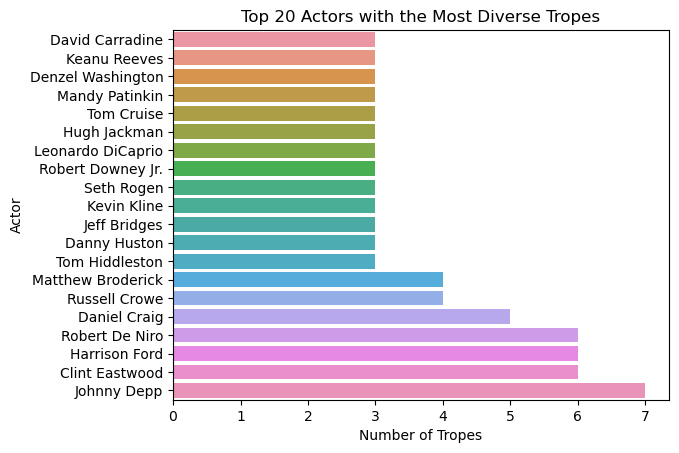

In [7]:
sns.barplot(data = tvtropes_per_actor.tail(20), x="num_tropes", y="actor", orient='h')
plt.xlabel('Number of Tropes')
plt.ylabel('Actor')
plt.title('Top 20 Actors with the Most Diverse Tropes')
plt.show()

### Analyse frequence of tropes when joined

In [81]:
tvtropes_personas_std = tvtropes_personas.copy()
tvtropes_personas_std['movie_name_standardized'] = tvtropes_personas_std['movie_name'].str.lower()

In [82]:
movies_std = movies.copy()
movies_std['movie_name_standardized'] = movies_std['movie_name'].str.lower()

In [83]:
movies_personas = movies_std.merge(tvtropes_personas_std, on='movie_name_standardized', how='inner')

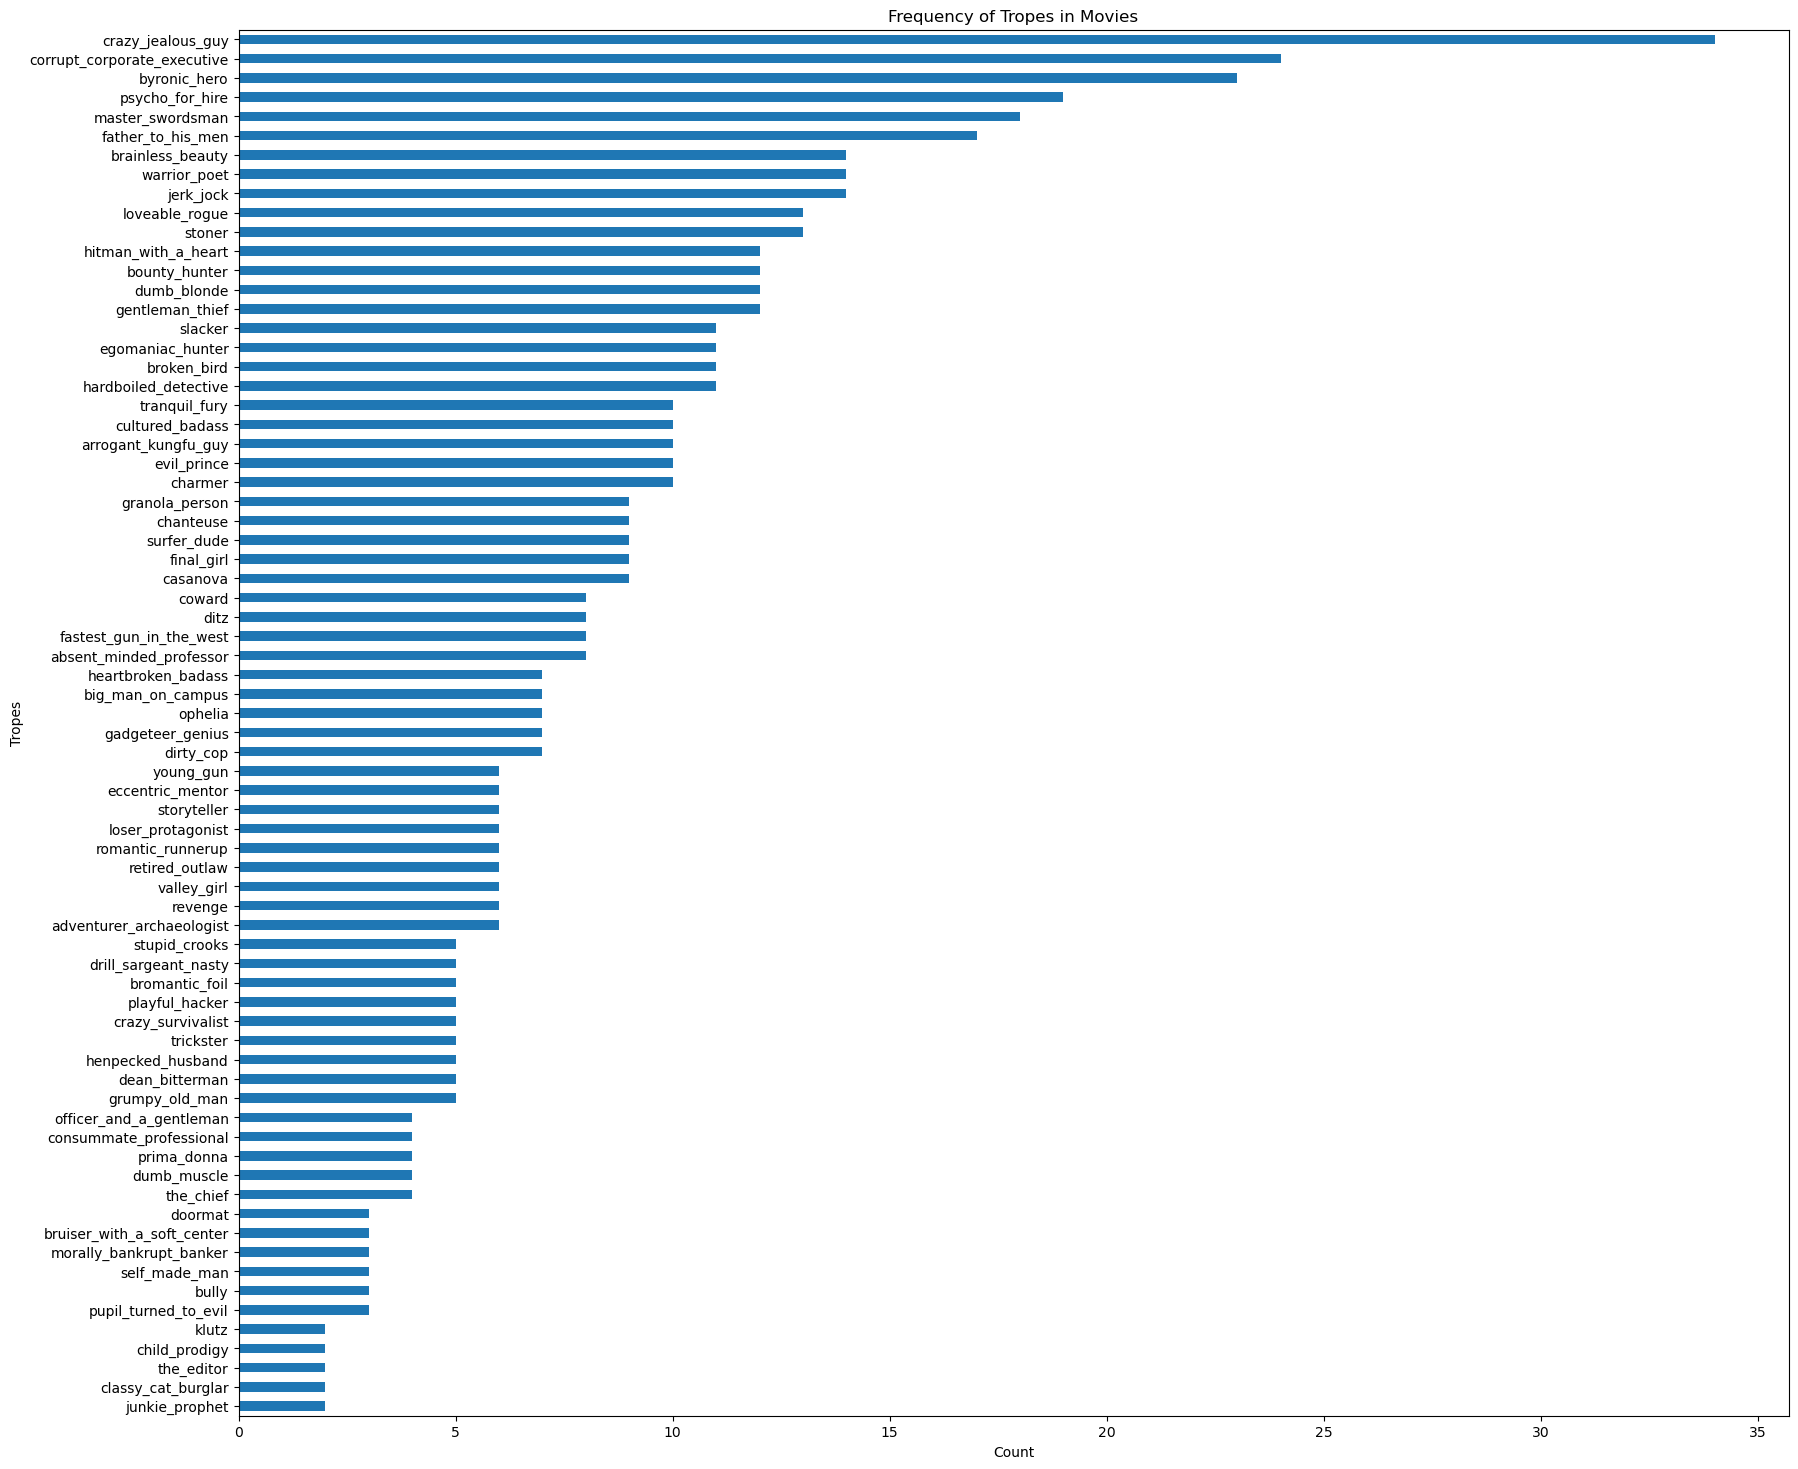

In [107]:
trope_value_counts = movies_personas['trope'].value_counts()

plt.figure(figsize=(20, 18))
trope_value_counts.plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Tropes')
plt.title('Frequency of Tropes in Movies')
plt.gca().invert_yaxis()
plt.show()

## CMU personas with characters

In [72]:
cmu_personas = load_personas()

In [73]:
cmu_personas.sample(5)

,freebase_id,wiki_id,movie_name,secondary_name,full_name,token_occurences,estimated_trope,trope_distrib
32845,e25,15901584,New Cutie Honey,Honey,Honey and the rest of the Hayamis fly,3,29,"[0.0, 0.05, 0.0, 0.0, 0.0, 0.05, 0.0, 0.0, 0.0..."
139014,e24,512161,Herbie Goes to Monte Carlo,driver,a rookie driver,4,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.36, 0.0, 0.0,..."
107974,e27,31828890,The Shortcut,Taylor,Taylor,14,21,"[0.0, 0.03, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
39083,e4,17228730,The Loneliness of the Long Distance Runner,they,young men,4,23,"[0.0, 0.0, 0.31, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0..."
93188,/m/0cl8zhl,28211095,Three,Adam,"Adam 's flat , where they partake in a passion...",7,49,"[0.0, 0.01, 0.13, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


In [74]:
movies_personas_cmu = cmu_personas.merge(actors_characters, left_on='freebase_id', right_on='freebase_map_id')

In [76]:
movies_personas_cmu.sample(5)

,freebase_id_x,wiki_id,movie_name,secondary_name,full_name,token_occurences,estimated_trope,trope_distrib,nconst,knownForTitles,...,release_date,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
5851,/m/0f12_v7,27381786,Julia's Eyes,Isaac,Isaac,15,21,"[0.0, 0.0, 0.06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",nm0392913,"tt0442353,tt1298554,tt0913425,tt0275491",...,2010-09-11,1957-04-20,M,NaN,None,Lluís Homar,53.0,/m/0f12_v7,/m/0h69yb9,/m/07yd8tm
4801,/m/0jvcqm,23808966,Bill & Ted's Excellent Adventure,"Bill S. Preston, Esq.",Bill,7,32,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",nm0935664,"tt4881578,tt0109838,tt1086064,tt14308574",...,1989-02-17,1965-07-17,M,NaN,/m/041rx,Alex Winter,23.0,/m/0jvcqm,/m/0g2jk0,/m/04xjzx
9123,/m/0k0fbk,5356013,Mann,Karan Dev Singh,both Dev and Priya,20,49,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",nm0451148,"tt0986264,tt2338151,tt5074352,tt0169102",...,1999-07-09,1965-03-14,M,1.68,/m/0dllcfn,Aamir Khan,34.0,/m/0k0fbk,/m/0gxp8gg,/m/015npr
4791,/m/03l9jml,2377503,Waiting...,Dean,his,5,2,"[0.0, 0.0, 0.77, 0.0, 0.0, 0.0, 0.08, 0.0, 0.0...",nm0519043,"tt0263488,tt0337978,tt0177789,tt0384793",...,2005-10-07,1978-06-02,M,1.74,/m/07hwkr,Justin Long,27.0,/m/03l9jml,/m/0h122nw,/m/07cjqy
3153,/m/05j2k4y,18711572,Kidnap,Kabir,he,54,49,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",nm1405359,"tt1667838,tt1934231,tt0473367,tt1034449",...,2008-10-02,1983-01-13,M,1.80,/m/04gfy7,Imran Khan,25.0,/m/05j2k4y,/m/02nwd40,/m/043nt7h


## Self-cooked personas

In [86]:
movies.head()

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,movie_languages,movie_countries,movie_genres,plot_summary
0,tt0000009,45,Romance,5.3,207,/m/02q23xk,10109752,Miss Jerry,1894-10-09,NaN,{'/m/06ppq': 'Silent film'},{'/m/09c7w0': 'United States of America'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",After finding out that her father is suffering...
1,tt0000147,100,"Documentary,News,Sport",5.3,484,/m/0czdh_n,28703057,The Corbett-Fitzsimmons Fight,1897-05-22,100000.0,{},{},{'/m/01z02hx': 'Sports'},The film no longer exists in its entirety; how...
2,tt0000574,70,"Action,Adventure,Biography",6.0,855,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,{'/m/02h40lc': 'English Language'},{'/m/0chghy': 'Australia'},"{'/m/0lsxr': 'Crime Fiction', '/m/06ppq': 'Sil...",The Story of the Kelly Gangs tone is of sorrow...
3,tt0000591,90,Drama,5.0,21,/m/07s67rr,4849466,L'Enfant prodigue,1907-06-20,NaN,{'/m/064_8sq': 'French Language'},{'/m/0f8l9c': 'France'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",None
4,tt0000679,120,"Adventure,Fantasy",5.1,68,/m/0fgfyy,5954041,The Fairylogue and Radio-Plays,1908-09-24,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06ppq': 'Silent film', '/m/01g6gs': 'Blac...",None


In [87]:
actors_characters.head()

,nconst,knownForTitles,tconst,characters,freebase_id,wiki_movie_id,release_date,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
0,nm0000001,"tt0045537,tt0053137,tt0050419,tt0072308",tt0025164,"[""Guy Holden""]",/m/0glnm,61169,1934,1899-05-10,M,1.750,/m/01qhm_,Fred Astaire,NaN,/m/0k557x,/m/0h184w0,/m/0h953
1,nm0002143,"tt0057193,tt0030241,tt0036613,tt0027125",tt0025164,"[""Egbert 'Pinky' Fitzgerald""]",/m/0glnm,61169,1934,1886-03-18,M,NaN,None,Edward Everett Horton,NaN,/m/0cs6brt,None,/m/0197p7
2,nm0000001,"tt0045537,tt0053137,tt0050419,tt0072308",tt0026942,"[""Huck Haines""]",/m/02x5h46,12800555,1935-03-08,1899-05-10,M,1.750,/m/01qhm_,Fred Astaire,NaN,/m/03l20gb,/m/0h184_z,/m/0h953
3,nm0000068,"tt0026942,tt0046375,tt0029284,tt0056412",tt0026942,"[""John Kent""]",/m/02x5h46,12800555,1935-03-08,1898-01-23,M,1.905,None,Randolph Scott,NaN,/m/03l20fw,/m/0h2qky5,/m/014y_c
4,nm0000001,"tt0045537,tt0053137,tt0050419,tt0072308",tt0027125,"[""Jerry Travers""]",/m/0gnjh,61501,1935,1899-05-10,M,1.750,/m/01qhm_,Fred Astaire,NaN,/m/0k77vk,/m/0h184_5,/m/0h953


In [92]:
all_data = movies.merge(actors_characters, how="inner", on=["tconst", "freebase_id", "wiki_movie_id"])

In [152]:
all_data.head()

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,...,release_date,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
0,tt0000574,70,"Action,Adventure,Biography",6.0,855,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,...,1906-12-26,1871,M,NaN,None,John Tait,NaN,/m/0k6ktp,None,/m/0k6ksg
1,tt0000574,70,"Action,Adventure,Biography",6.0,855,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,...,1906-12-26,1880,M,NaN,None,Nicholas Brierley,NaN,/m/0k6ktc,None,/m/0k6ks2
2,tt0000574,70,"Action,Adventure,Biography",6.0,855,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,...,1906-12-26,\N,None,NaN,None,Norman Campbell,NaN,/m/0bxl4zk,None,/m/0bxl4z5
3,tt0000591,90,Drama,5.0,21,/m/07s67rr,4849466,L'Enfant prodigue,1907-06-20,NaN,...,1907-06-20,\N,M,NaN,None,Henri Gouget,NaN,/m/0n5_12f,None,/m/0n5_12j
4,tt0000591,90,Drama,5.0,21,/m/07s67rr,4849466,L'Enfant prodigue,1907-06-20,NaN,...,1907-06-20,1874-01-14,M,NaN,None,Georges Wague,NaN,/m/0n5_11r,None,/m/0n5_11v


In [230]:
all_data.columns

Index(['tconst', 'runtimeMinutes', 'genres', 'averageRating', 'numVotes',
       'freebase_id', 'wiki_movie_id', 'movie_name', 'movie_release_date',
       'box_office', 'movie_languages', 'movie_countries', 'movie_genres',
       'plot_summary', 'nconst', 'knownForTitles', 'characters',
       'release_date', 'actor_birth', 'actor_gender', 'actor_height',
       'actor_ethnicity', 'actor_name', 'release_actor_age', 'freebase_map_id',
       'freebase_character_id', 'freebase_actor_id'],
      dtype='object')

### Based on movie genre

In [196]:
movie_genre_per_actor = all_data[["nconst", "actor_name", "movie_genres"]].copy()

In [197]:
movie_genre_per_actor["genres_flattened"] = movie_genre_per_actor["movie_genres"].apply(lambda genres: list(genres.values()))

In [198]:
movie_genre_per_actor = movie_genre_per_actor.drop("movie_genres", axis=1)

In [200]:
movie_genre_per_actor = movie_genre_per_actor.groupby(["nconst", "actor_name"]).agg(list).reset_index()

In [202]:
movie_genre_per_actor["total_movies"] = movie_genre_per_actor["genres_flattened"].apply(len)

In [203]:
movie_genre_per_actor["genres_flattened"] = movie_genre_per_actor["genres_flattened"].apply(lambda ls: [item for row in ls for item in row])

In [204]:
movie_genre_per_actor["genres_freq"] = movie_genre_per_actor["genres_flattened"].apply(lambda ls: dict(sorted(dict(Counter(ls)).items(), key=lambda item: item[1], reverse=True)))

In [205]:
movie_genre_per_actor = movie_genre_per_actor.drop("genres_flattened", axis=1)

In [209]:
movie_genre_per_actor.head()

,nconst,actor_name,total_movies,genres_freq
0,nm0000001,Fred Astaire,33,"{'Musical': 28, 'Comedy': 20, 'Romance Film': ..."
1,nm0000004,John Belushi,6,"{'Comedy': 6, 'Action/Adventure': 3, 'Action':..."
2,nm0000007,Humphrey Bogart,68,"{'Drama': 52, 'Black-and-white': 41, 'Crime Fi..."
3,nm0000008,Marlon Brando,38,"{'Drama': 24, 'Romance Film': 9, 'Action/Adven..."
4,nm0000009,Richard Burton,48,"{'Drama': 37, 'Romance Film': 15, 'War film': ..."


#### Distribution of some actors

In [225]:
top_actors = movie_genre_per_actor.sort_values("total_movies", ascending=False).copy().head()

In [226]:
actor_1 = top_actors["genres_freq"].iloc[0]

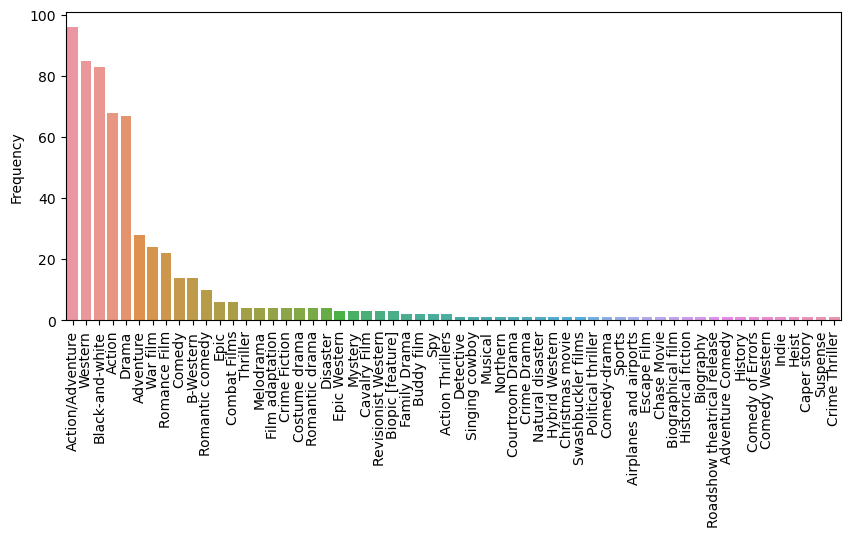

In [227]:
plt.figure(figsize=(10, 4))
sns.barplot(x=list(actor_1.keys()), y=list(actor_1.values()))
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

In [228]:
actor_2 = top_actors["genres_freq"].iloc[1]

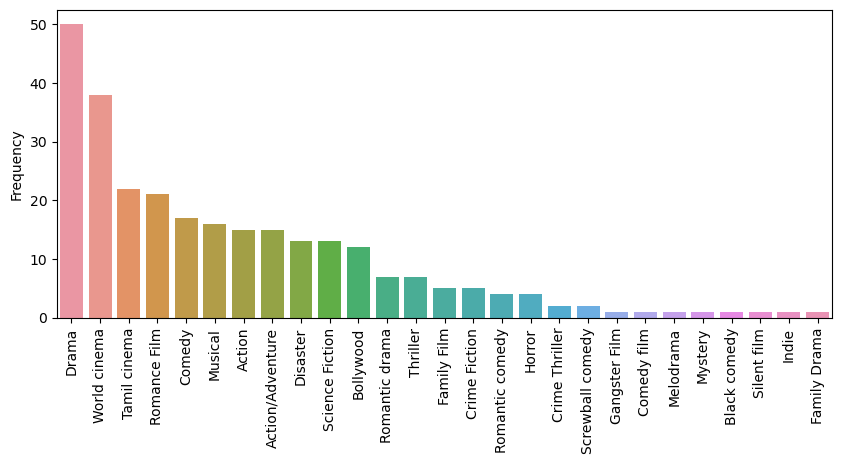

In [229]:
plt.figure(figsize=(10, 4))
sns.barplot(x=list(actor_2.keys()), y=list(actor_2.values()))
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

### Based on runtime minutes

In [274]:
runtime_per_actor = all_data[["nconst", "actor_name", "runtimeMinutes"]].copy()

In [275]:
runtime_per_actor = runtime_per_actor[runtime_per_actor["runtimeMinutes"] != "\\N"]

In [276]:
runtime_per_actor = runtime_per_actor.groupby(["nconst", "actor_name"]).agg(list).reset_index()

In [277]:
runtime_per_actor["runtimeMinutes"] = runtime_per_actor["runtimeMinutes"].apply(lambda ls: list(map(lambda elem: int(elem), ls)))

In [279]:
runtime_per_actor['len'] = runtime_per_actor['runtimeMinutes'].apply(len)
runtime_per_actor = runtime_per_actor.sort_values(by='len', ascending=False).drop(columns='len')

#### Distribution of some actors

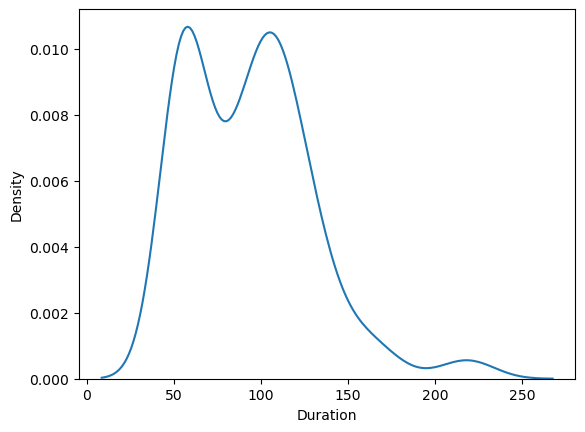

In [281]:
sns.kdeplot(runtime_per_actor["runtimeMinutes"].iloc[0])
plt.ylabel("Density")
plt.xlabel("Duration")
plt.show()

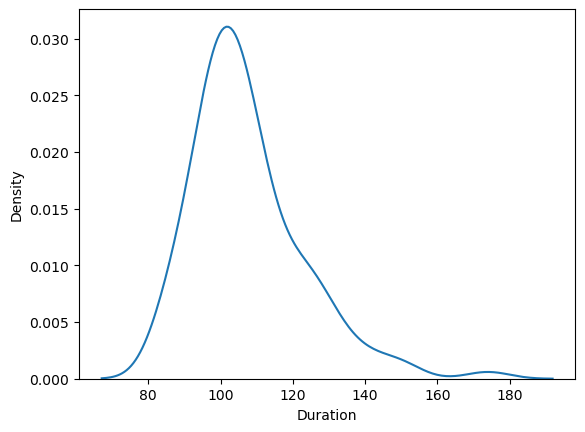

In [282]:
sns.kdeplot(runtime_per_actor["runtimeMinutes"].iloc[1])
plt.ylabel("Density")
plt.xlabel("Duration")
plt.show()